In [1]:
import geopandas as gpd
import os

import xscen as xs
from xscen.config import CONFIG
import figanos.matplotlib as fg

from plot_settings import save_plot, DPI

fg.utils.set_mpl_style("ouranos")
xs.load_config("../paths_obs.yml", "../config_obs.yml", verbose=(__name__ == "__main__"), reset=True)

pcat = xs.ProjectCatalog(CONFIG["paths"]["project_catalog"])
pcat_df = pcat.df

2025-08-29 14:03:56 INFO     xscen.config    Updated the config with ../paths_obs.yml.
2025-08-29 14:03:56 INFO     xscen.config    Updated the config with ../config_obs.yml.


In [2]:
# === Load project catalog and region shapefile ===
pcat = xs.ProjectCatalog(CONFIG["paths"]["project_catalog"])
pcat_df = pcat.df

fig_path = CONFIG["paths"]["figures"]

gdf = gpd.read_file("../" + CONFIG["regional_mean"]["region"]["shape"])
gdf["centroid_y"] = gdf.geometry.centroid.y
REGION_ORDER = gdf.sort_values("centroid_y")["name"].tolist()
all_regions = REGION_ORDER
HORIZON="1981-2010"

variable_mapping = {
    "pr_mean_annual_rmse": "pr_mean_annual_clim_mean",
    "pr_mean_seasonal_rmse": "pr_mean_seasonal_clim_mean",
    "tg_mean_annual_rmse": "tg_mean_annual_clim_mean",
    "tg_mean_seasonal_rmse": "tg_mean_seasonal_clim_mean"
}

fig_path = CONFIG["paths"]["figures"]

/tmp/ipykernel_4097826/1636174333.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



In [3]:
# === Get sorted list of variables ===
performance_pcat_df = pcat_df[pcat_df["processing_level"] == "regional_mean"]
performance_variable_groups = performance_pcat_df["variable"].unique()
performance_variables = sorted(set(item for group in performance_variable_groups for item in group))

/tmp/ipykernel_4097826/753061003.py:29: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/tmp/ipykernel_4097826/753061003.py:145: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
/tmp/ipykernel_4097826/753061003.py:147: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.


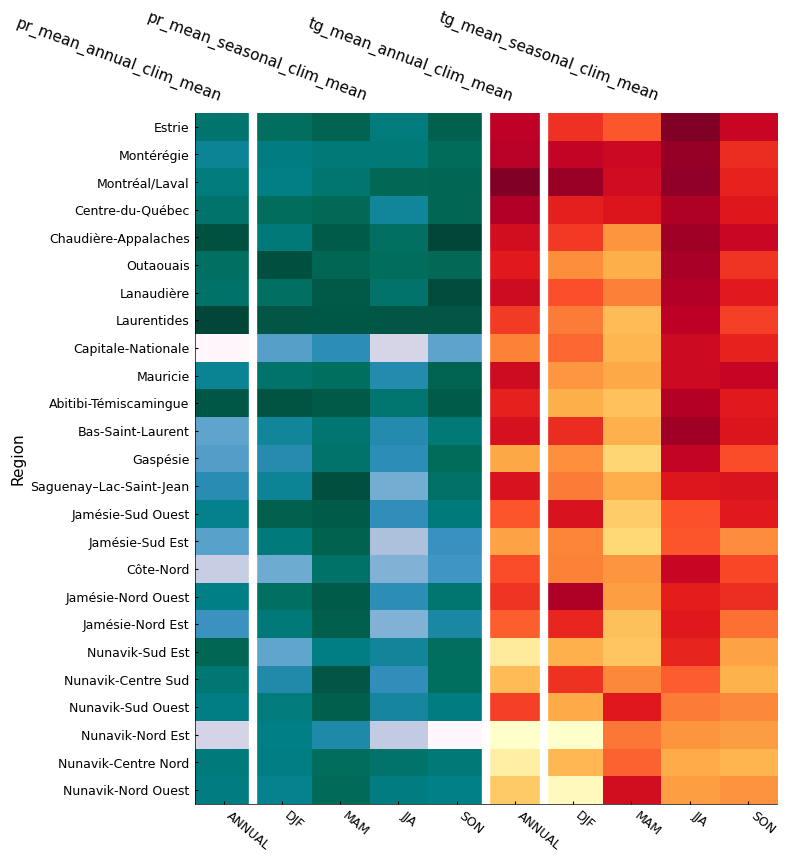

In [4]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm

def plot_coherence_heatmap(
    pcat,
    performance_variables,
    variable_mapping,
    HORIZON="1981-2010",
    season_order_global=("ANNUAL","DJF","MAM","JJA","SON"),
    subset_sources=None,
    pr_cmap_name="PuBuGn",
    tg_cmap_name="YlOrRd",
    group_linewidth=6,
    group_linecolor="white",
    figsize_per_col=0.5,
    figsize_per_row=0.35,
):
    """Create a matplotlib heatmap of per-region coherence (std across sources) 
    aligned to each performance variable's available seasons."""

    # ---- 0) Region order from shapefile (ALL regions, south -> north) ----
    gdf = gpd.read_file("../" + CONFIG["regional_mean"]["region"]["shape"])
    gdf["centroid_y"] = gdf.geometry.centroid.y
    REGION_ORDER = gdf.sort_values("centroid_y")["name"].tolist()
    region_index = pd.Index(REGION_ORDER, name="region")

    # ---- 1) Gather per-variable data ----
    per_var_info = []
    for perf_var in performance_variables:
        perf_ds = pcat.search(processing_level="regional_mean", variable=perf_var).to_dataset()
        if perf_var not in perf_ds:
            print(f"✖ Performance variable '{perf_var}' not found, skipping.")
            continue
        perf_da = perf_ds[perf_var]

        if subset_sources is not None and "source" in perf_da.dims:
            perf_da = perf_da.sel(source=subset_sources)

        if "season" not in perf_da.dims:
            print(f"✖ '{perf_var}' is missing a 'season' dimension, skipping.")
            continue

        perf_seasons = []
        for s in perf_da["season"].values:
            s = str(s)
            perf_seasons.append("ANNUAL" if s.lower() == "annual" else s)
        perf_da = perf_da.sel(season=perf_da["season"]).assign_coords(season=perf_seasons)

        var_seasons = [s for s in season_order_global if s in perf_da["season"].values]
        var_seasons += [s for s in perf_da["season"].values if s not in var_seasons]

        if perf_var not in variable_mapping:
            print(f"✖ No coherence mapping for '{perf_var}', skipping.")
            continue
        coh_var = variable_mapping[perf_var]  # <-- coherence variable name

        coh_ds = pcat.search(processing_level="coherence", variable=coh_var).to_dataset()
        if coh_var not in coh_ds:
            print(f"✖ '{coh_var}' not found in coherence dataset, skipping.")
            continue

        coh_da_all = coh_ds[coh_var]

        if "horizon" in coh_da_all.coords:
            if HORIZON not in coh_da_all["horizon"].values:
                print(f"✖ Horizon '{HORIZON}' not found for '{coh_var}', skipping.")
                continue
            coh_da_all = coh_da_all.sel(horizon=HORIZON)

        if subset_sources is not None and "source" in coh_da_all.dims:
            coh_da_all = coh_da_all.sel(source=subset_sources)

        if "source" in coh_da_all.dims:
            coh_da_all = coh_da_all.std(dim="source")

        if "season" in coh_da_all.dims:
            coh_seasons = []
            for s in coh_da_all["season"].values:
                s = str(s)
                coh_seasons.append("ANNUAL" if s.lower() == "annual" else s)
            coh_da_all = coh_da_all.sel(season=coh_da_all["season"]).assign_coords(season=coh_seasons)

        if "season" in coh_da_all.dims:
            valid = [s for s in var_seasons if s in list(coh_da_all["season"].values)]
            if len(valid) < len(var_seasons):
                parts = []
                for s in var_seasons:
                    if s in valid:
                        parts.append(coh_da_all.sel(season=s))
                    else:
                        parts.append(coh_da_all.isel(season=0, drop=True) * np.nan)
                coh_da = xr.concat(parts, dim=pd.Index(var_seasons, name="season"))
            else:
                coh_da = coh_da_all.sel(season=var_seasons)
        else:
            coh_da = coh_da_all.expand_dims(season=pd.Index(var_seasons, name="season"))

        per_var_info.append({
            "perf_var": perf_var,
            "coh_var": coh_var,       # <-- ADDED: keep coherence name
            "seasons": var_seasons,
            "coh_da": coh_da,
        })

    if not per_var_info:
        print("No data to display.")
        return

    # ---- 2) Build coherence matrix ----
    total_cols = sum(len(info["seasons"]) for info in per_var_info)
    n_rows = len(region_index)
    coherence_img = np.full((n_rows, total_cols), np.nan)
    col_labels, groups = [], []

    col0 = 0
    for info in per_var_info:
        seasons = info["seasons"]
        coh_da = info["coh_da"]

        for j, s in enumerate(seasons):
            col_labels.append(str(s))
            vals = coh_da.sel(season=s).reindex(region=region_index).to_numpy()
            coherence_img[:, col0 + j] = vals

        groups.append((col0, col0 + len(seasons), info["coh_var"]))  # <-- CHANGED: label by coherence var
        col0 += len(seasons)

    # ---- 3) Create color-mapped image ----
    colored_img = np.zeros((n_rows, total_cols, 4))  # RGBA

    col_idx = 0
    for info in per_var_info:
        n_seasons = len(info["seasons"])
        var_data = coherence_img[:, col_idx:col_idx + n_seasons]

        # Choose colormap based on **coherence** variable name
        varname = info["coh_var"].lower()  # <-- CHANGED: use coherence var
        if "pr" in varname:
            cmap = cm.get_cmap(pr_cmap_name).reversed()
        elif "tg" in varname or "tas" in varname:
            cmap = cm.get_cmap(tg_cmap_name).reversed()
        else:
            cmap = cm.get_cmap("Greys").reversed()

        valid_data = var_data[np.isfinite(var_data)]
        if len(valid_data) > 0:
            vmin, vmax = valid_data.min(), valid_data.max()
            if vmax > vmin:
                norm = Normalize(vmin=vmin, vmax=vmax)
                for i in range(n_rows):
                    for j in range(n_seasons):
                        val = var_data[i, j]
                        if np.isfinite(val):
                            colored_img[i, col_idx + j] = cmap(norm(val))
                        else:
                            colored_img[i, col_idx + j] = [1, 1, 1, 0]
            else:
                mid_color = cmap(0.5)
                for i in range(n_rows):
                    for j in range(n_seasons):
                        if np.isfinite(var_data[i, j]):
                            colored_img[i, col_idx + j] = mid_color
                        else:
                            colored_img[i, col_idx + j] = [1, 1, 1, 0]

        col_idx += n_seasons

    # ---- 4) Plot ----
    fig_w = max(8, figsize_per_col * total_cols)
    fig_h = max(4.5, figsize_per_row * n_rows)
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))
    ax.imshow(colored_img, interpolation="none", aspect="auto", origin="upper")
    ax.grid(False)

    ax.set_yticks(np.arange(n_rows))
    ax.set_yticklabels(region_index, fontsize=9)
    ax.set_xticks(np.arange(total_cols))
    ax.set_xticklabels(col_labels, rotation=-40, ha="left", va="top", fontsize=9)
    ax.set_xlabel("")
    ax.set_ylabel("Region")

    # Group labels and separators
    for (i0, i1, lab) in groups:
        x_center = (i0 + i1 - 1) / 2
        ax.text(x_center, -0.8, lab, ha="right", va="bottom", rotation=-20, fontsize=11)

    for (i0, i1, _) in groups[:-1]:
        ax.vlines(i1 - 0.5, -0.5, n_rows - 0.5,
                  colors=group_linecolor, linewidth=group_linewidth, zorder=5)

    plt.tight_layout()

    save_plot(fig, processing_level="coherence", horizon="1981-2010", freq="fx", file_name="coherence_heatmap")
    
    plt.show()

# === Usage Example ===
plot_coherence_heatmap(
     pcat=pcat,
     performance_variables=performance_variables,
     variable_mapping=variable_mapping,
     HORIZON=HORIZON,
     season_order_global=("ANNUAL","DJF","MAM","JJA","SON"),
     subset_sources=None,
)

2025-08-29 14:03:58 INFO     xscen.config    Updated the config with ../paths_obs.yml.
2025-08-29 14:03:58 INFO     xscen.config    Updated the config with ../config_obs.yml.
/tmp/ipykernel_4097826/1565581493.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Processing: pr_mean_annual_clim_mean


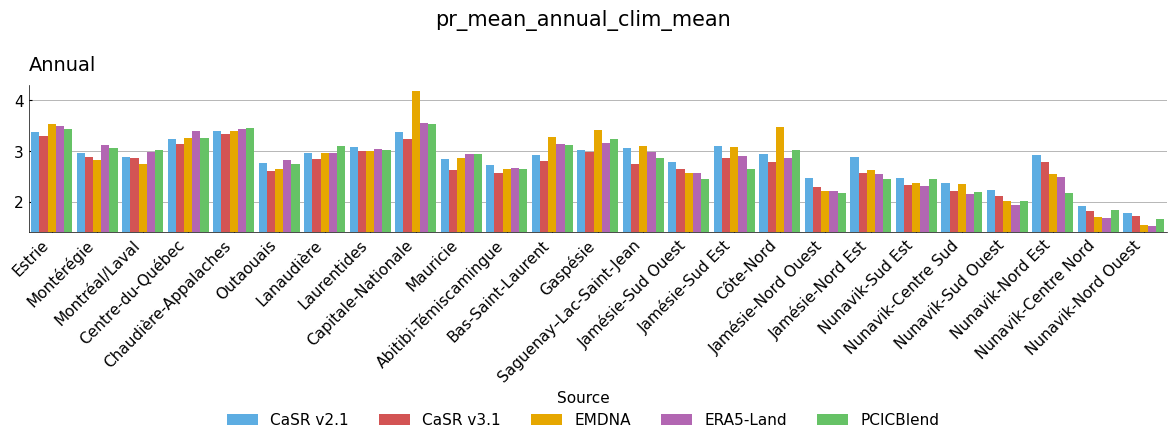

Processing: pr_mean_seasonal_clim_mean


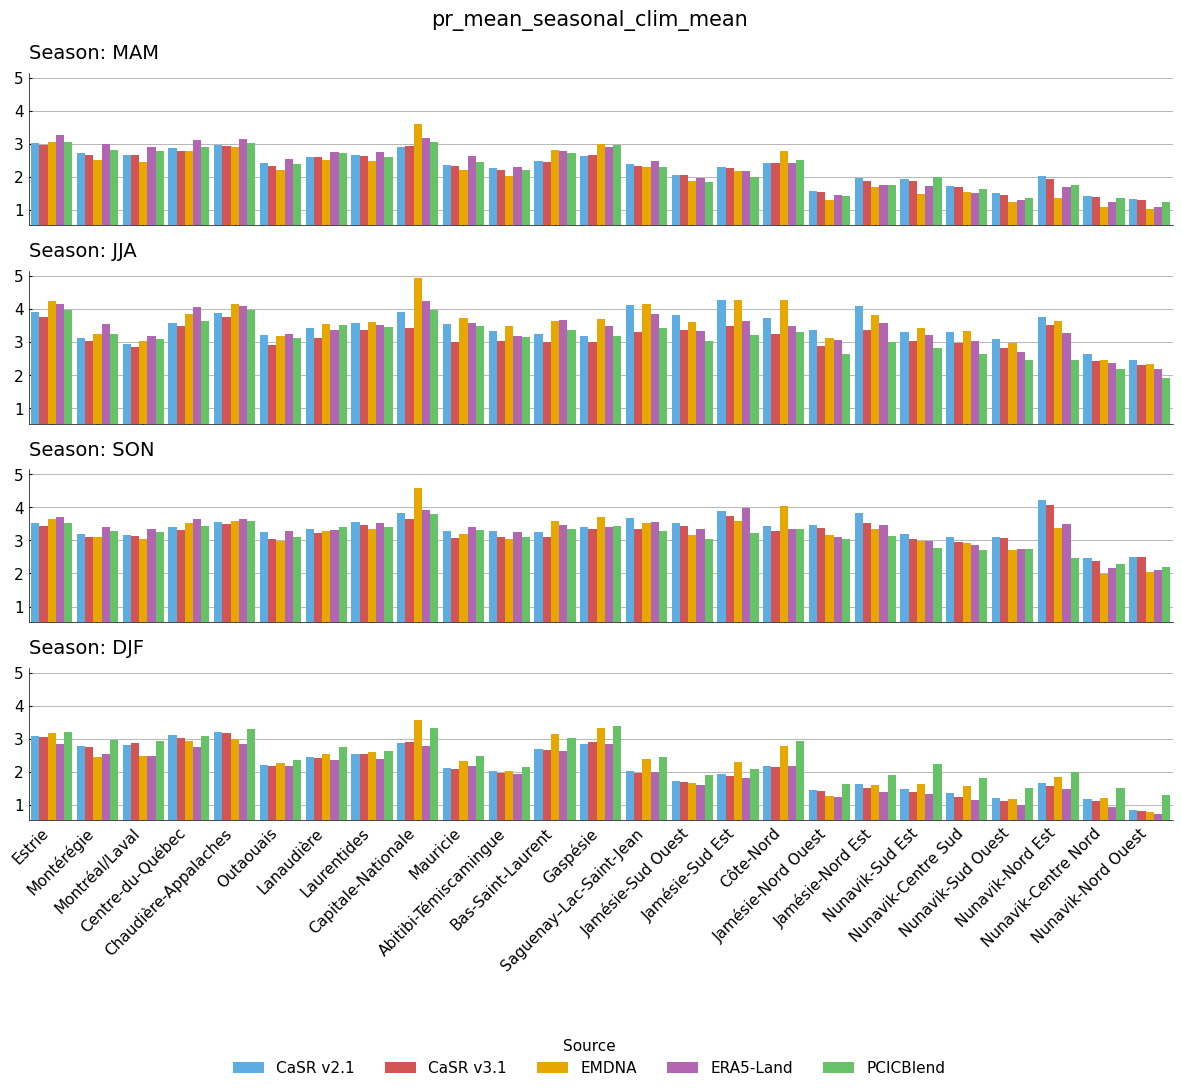

Processing: tg_mean_annual_clim_mean


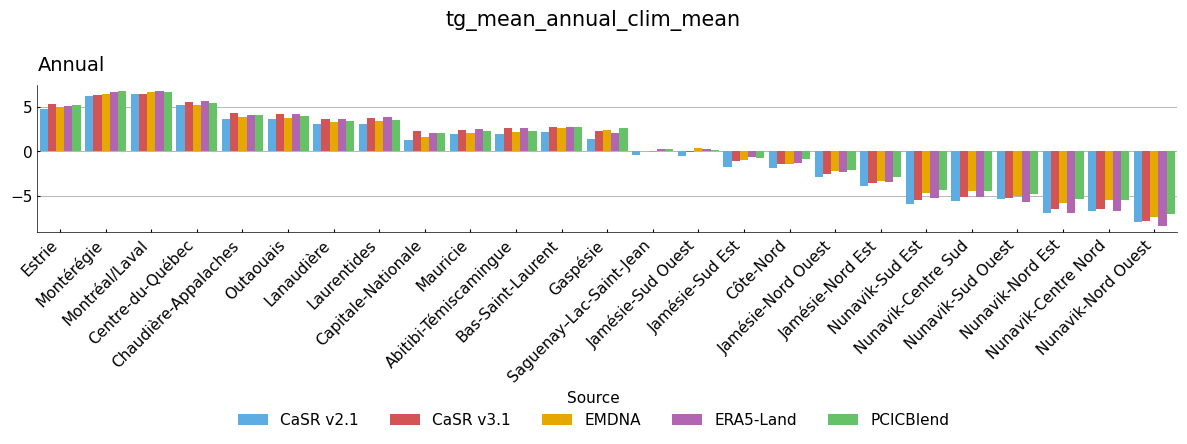

Processing: tg_mean_seasonal_clim_mean


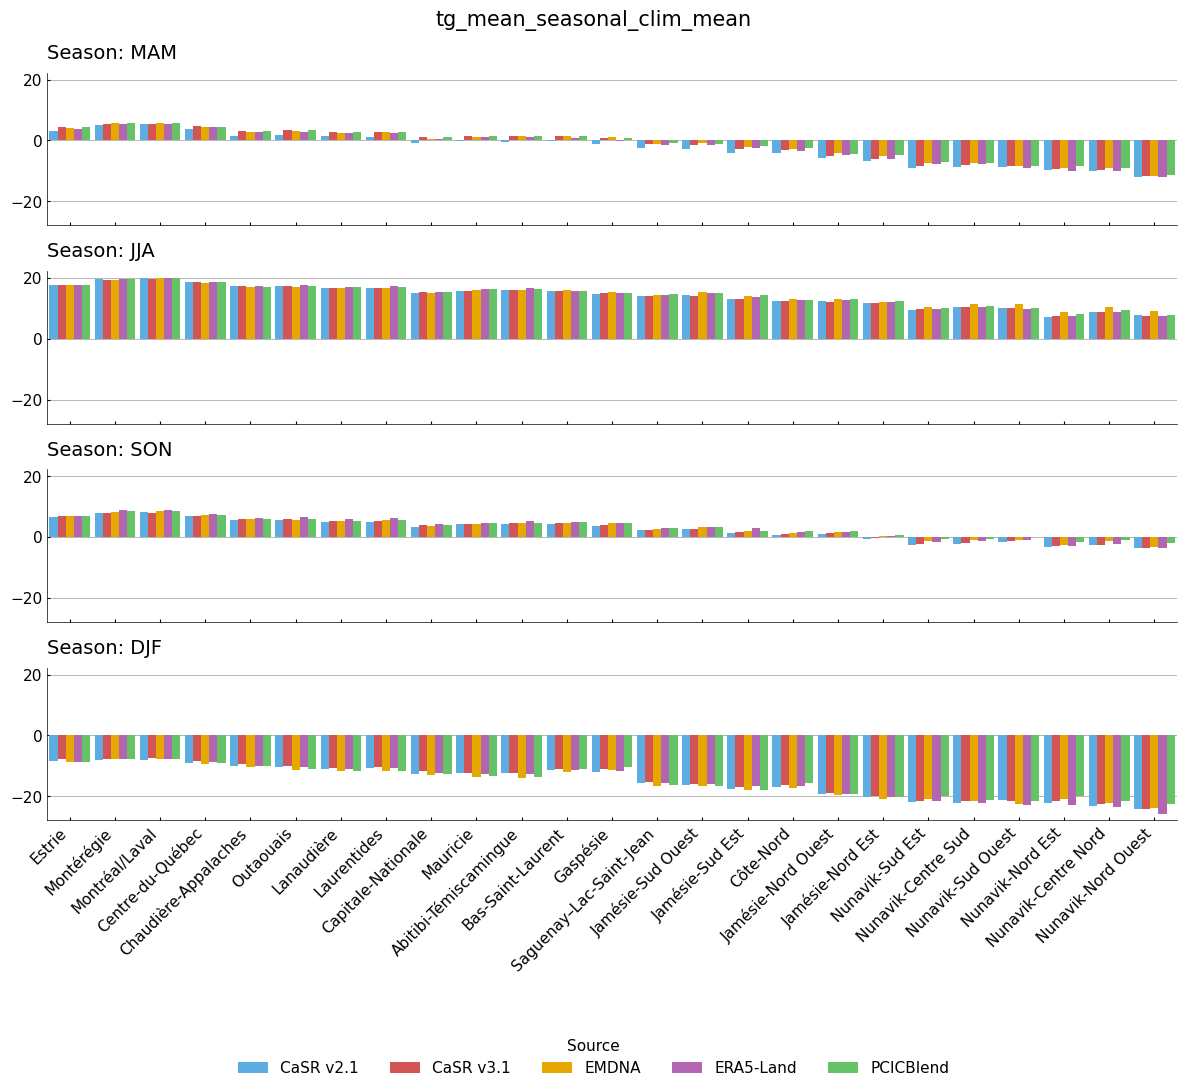

In [5]:
import xscen as xs
from xscen.config import CONFIG
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import geopandas as gpd
from plot_settings import SOURCE_COLORS, save_plot

# =========================
# Setup
# =========================
xs.load_config("../paths_obs.yml", "../config_obs.yml", verbose=(__name__ == "__main__"), reset=True)
pcat = xs.ProjectCatalog(CONFIG["paths"]["project_catalog"])

# Load shapefile and compute centroids
gdf = gpd.read_file("../" + CONFIG["regional_mean"]["region"]["shape"])
gdf["centroid"] = gdf.geometry.centroid
gdf["centroid_x"] = gdf["centroid"].x
gdf["centroid_y"] = gdf["centroid"].y

# Sort regions south to north
REGION_ORDER = gdf.sort_values("centroid_y")["name"].tolist()

# Get list of coherence variables
df = pcat.df
df = df[df["processing_level"] == "coherence"]
variables = sorted({v for group in df["variable"].unique() for v in group})

# Helper: pick a single horizon if present
def select_one_horizon(ds, preferred="1981-2010"):
    if "horizon" in ds.dims or "horizon" in ds.coords:
        try:
            return ds.sel(horizon=preferred)
        except Exception:
            return ds.isel(horizon=0)
    return ds

# =========================
# Loop over variables
# =========================
for var in variables:
    print(f"Processing: {var}")
    try:
        ds_all = pcat.search(processing_level="coherence", variable=var).to_dataset().compute()
        ds_all = select_one_horizon(ds_all)  # <-- ensure 1D by region per source
    except Exception as e:
        print(f"Failed to load dataset for {var}: {e}")
        continue

    if var not in ds_all:
        print(f"Variable '{var}' not found in dataset.")
        continue

    # Handle seasonal vs annual
    has_season = ("season" in ds_all.coords) or ("season" in ds_all.dims)
    seasons = ds_all["season"].values if has_season else [None]

    n_rows = len(seasons)
    fig_height = 2.5 * n_rows if n_rows > 1 else 4
    fig, axes = plt.subplots(nrows=n_rows, ncols=1, figsize=(12, fig_height), sharex=True)
    if n_rows == 1:
        axes = [axes]

    regions = REGION_ORDER
    sources = sorted(ds_all["source"].values.tolist())

    da_all = ds_all[var]
    ymin = float(da_all.min())
    ymax = float(da_all.max())
    y_pad = 0.05 * (ymax - ymin) if ymax > ymin else 1.0
    bar_width = 0.9 / max(len(sources), 1)

    for i, season in enumerate(seasons):
        ax = axes[i]
        if season is None:
            ds = ds_all
            title_str = "Annual"
        else:
            ds = ds_all.sel(season=season)
            title_str = f"Season: {season}"

        # Reindex to region order
        da = ds[var].reindex(region=regions)

        # Keep nstation aligned with the same horizon/season selection
        if "nstation" in ds:
            nstation_season = ds["nstation"].reindex(region=regions).values
        else:
            nstation_season = np.full(len(regions), np.nan)

        x = np.arange(len(regions))

        # Plot bars for each source (y must be 1-D by region)
        for j, source in enumerate(sources):
            y = da.sel(source=source).values
            # If y still has extra dims, squeeze them now
            y = np.asarray(y)
            if y.ndim > 1:
                y = np.squeeze(y)
            color = SOURCE_COLORS.get(source, None)

            for k, (xpos, yval) in enumerate(zip(x, y)):
                bar_pos = xpos + j * bar_width - (len(sources) - 1) * bar_width / 2
                ax.bar(
                    bar_pos, yval,
                    width=bar_width,
                    color=color,
                    label=source if i == 0 and k == 0 else None
                )

        # Annotate station counts above tallest bar in each region
        for k, _region_name in enumerate(regions):
            nst = nstation_season[k]
            if not np.isfinite(nst):
                continue
            region_vals = [da.sel(source=s).isel(region=k).item() for s in sources]
            max_height = np.nanmax(region_vals)
            if np.isfinite(max_height):
                ax.annotate(
                    f"{int(nst)}",
                    xy=(x[k], max_height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha="center", va="bottom", fontsize=8
                )

        ax.set_title(title_str, loc="left")
        ax.set_ylim(ymin - y_pad, ymax + y_pad)
        ax.grid(True, axis="y")

    axes[-1].set_xticks(x)
    axes[-1].set_xticklabels(regions, rotation=45, ha="right")
    axes[-1].set_xlim(-0.5, len(regions) - 0.5)

    handles, labels = axes[0].get_legend_handles_labels()
    uniq = dict(zip(labels, handles))
    if uniq:
        fig.legend(uniq.values(), uniq.keys(), title="Source", loc="lower center",
                   ncol=len(uniq), bbox_to_anchor=(0.5, -0.1))

    fig.suptitle(var, fontsize=15, y=0.98)
    fig.subplots_adjust(bottom=0.18, top=0.9)
    plt.tight_layout()

    # Keep horizon argument consistent with the horizon we picked
    save_plot(fig, processing_level="coherence", horizon="1981-2010", freq="fx", file_name=f"{var}_bars")
    plt.show()
